In [488]:
%matplotlib inline

In [492]:
import pandas as pd
import numpy as np
import urllib
import requests

import matplotlib.pyplot as plt

from pandas.core.frame import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

In [240]:
random_seed = 0
size_test = 1 / 10
size_validation = size_test / (1 - size_test)  # to get to 1/10

headers_link = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names'
file_path = 'resources/datasets/kddcup.data_10_percent'

In [301]:
def pred_actual_table(pred, actual):
    q = pd.DataFrame({'predicted': pred, 'actual': actual}).groupby(['predicted', 'actual']).size()  # / len(y)
    return pd.DataFrame({'counts': q, 'pct': q / q.sum()})

In [3]:
contents = requests.get(headers_link).text
headers = [x.split(':')[0] for x in contents.split('\n')[1:]]
headers[-1] = 'label'

In [4]:
df = pd.read_csv(file_path, header=None, names=headers)

In [6]:
df.shape

(494021, 42)

In [7]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [184]:
df.flag.nunique()

11

In [185]:
df.service.nunique()

66

In [9]:
df.protocol_type.value_counts()

icmp    283602
tcp     190065
udp      20354
Name: protocol_type, dtype: int64

In [10]:
df.shape

(494021, 42)

In [11]:
df.label.value_counts(normalize=True)

smurf.              0.568377
neptune.            0.216997
normal.             0.196911
back.               0.004459
satan.              0.003216
ipsweep.            0.002524
portsweep.          0.002105
warezclient.        0.002065
teardrop.           0.001982
pod.                0.000534
nmap.               0.000468
guess_passwd.       0.000107
buffer_overflow.    0.000061
land.               0.000043
warezmaster.        0.000040
imap.               0.000024
rootkit.            0.000020
loadmodule.         0.000018
ftp_write.          0.000016
multihop.           0.000014
phf.                0.000008
perl.               0.000006
spy.                0.000004
Name: label, dtype: float64

In [12]:
df_ = df[df.label.isin(['normal.', 'ipsweep.'])]
df_ = df_.reset_index(drop=True)

In [13]:
df_.label.value_counts(normalize=True)

normal.     0.987343
ipsweep.    0.012657
Name: label, dtype: float64

In [14]:
df_.shape

(98525, 42)

In [199]:
x = df_[df.columns.difference(['label'])]
y = df_.label == 'normal.'

In [200]:
categorical_cols = [col for col in x.columns if df.dtypes[col] == object]

In [201]:
x[categorical_cols].nunique()

flag              9
protocol_type     3
service          32
dtype: int64

In [202]:
y.nunique()

2

In [203]:
x_ = pd.get_dummies(x, columns=categorical_cols)

In [204]:
x_.shape

(98525, 82)

In [21]:
x_.head()

,count,diff_srv_rate,dst_bytes,dst_host_count,dst_host_diff_srv_rate,dst_host_rerror_rate,dst_host_same_src_port_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_count,...,service_shell,service_smtp,service_ssh,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_whois
0,8,0.0,5450,9,0.0,0.0,0.11,1.0,0.0,9,...,0,0,0,0,0,0,0,0,0,0
1,8,0.0,486,19,0.0,0.0,0.05,1.0,0.0,19,...,0,0,0,0,0,0,0,0,0,0
2,8,0.0,1337,29,0.0,0.0,0.03,1.0,0.0,29,...,0,0,0,0,0,0,0,0,0,0
3,6,0.0,1337,39,0.0,0.0,0.03,1.0,0.0,39,...,0,0,0,0,0,0,0,0,0,0
4,6,0.0,2032,49,0.0,0.0,0.02,1.0,0.0,49,...,0,0,0,0,0,0,0,0,0,0


In [22]:
y.value_counts(normalize=True)

True     0.987343
False    0.012657
Name: label, dtype: float64

In [24]:
%%time
iforest = IsolationForest(contamination=0.012657, behaviour='new')
iforest.fit(x_)

CPU times: user 6.36 s, sys: 1.2 s, total: 7.56 s
Wall time: 7.12 s


In [25]:
x_predicted = iforest.predict(x_)

In [26]:
pd.Series(x_predicted).value_counts(normalize=True)

 1    0.987333
-1    0.012667
dtype: float64

In [27]:
q = pd.DataFrame({'predicted': x_predicted == 1, 'actual': y}).groupby(['predicted', 'actual']).size()  # / len(y)
print(pd.DataFrame({'counts': q, 'pct': q / q.sum()}))

                  counts       pct
predicted actual                  
False     False      682  0.006922
          True       566  0.005745
True      False      565  0.005735
          True     96712  0.981599


In [28]:
f1_score(y, x_predicted == 1)

0.9941867338284803

In [29]:
prev = y.value_counts(normalize=True)

In [30]:
prev

True     0.987343
False    0.012657
Name: label, dtype: float64

In [31]:
list(prev)

[0.987343313879726, 0.012656686120274043]

In [32]:
{1: 2}.items()

dict_items([(1, 2)])

In [33]:
# random labels with same prevalence
pd.Series([
    f1_score(y, np.random.choice([1, 0], p=prev, size=len(y)) == 1)
    for _ in range(100)
]).median()


0.987395249446209

In [34]:
# random labeling, AUC score
pd.Series([
    roc_auc_score(y, np.random.choice([1, 0], p=prev, size=len(y)) == 1)
    for _ in range(100)
]).describe()

count    100.000000
mean       0.499971
std        0.001655
min        0.496613
25%        0.498861
50%        0.499708
75%        0.500968
max        0.504802
dtype: float64

In [35]:
pd.DataFrame({'predicted': np.random.choice([1, 0], p=prev, size=len(y)) == 1, 'actual': y}) \
.groupby(['predicted', 'actual']).size()  # / len(y)

predicted  actual
False      False        17
           True       1199
True       False      1230
           True      96079
dtype: int64

In [36]:
precision_recall_fscore_support(y, x_predicted == 1)

(array([0.54647436, 0.99419184]),
 array([0.54691259, 0.99418162]),
 array([0.54669339, 0.99418673]),
 array([ 1247, 97278]))

In [37]:
scores = iforest.score_samples(x_)

In [38]:
scores

array([-0.35706138, -0.351111  , -0.34808028, ..., -0.43316349,
       -0.37764098, -0.36374283])

In [39]:
pd.Series(scores).describe()

count    98525.000000
mean        -0.379493
std          0.057235
min         -0.623232
25%         -0.415119
50%         -0.358780
75%         -0.330637
max         -0.320248
dtype: float64

In [41]:
scores.reshape(-1).shape

(98525,)

In [42]:
scores_scaled = MinMaxScaler().fit_transform(scores[:, pd.np.newaxis])

In [43]:
roc_auc_score(y, scores_scaled)

0.9912242804882666

In [44]:
average_precision_score(y, scores_scaled)

0.9998863994901188

### Progress

In [242]:
x_.shape

(98525, 82)

In [243]:
y.shape

(98525,)

In [244]:
x_train, x_test, y_train, y_test = train_test_split(x_, y, test_size=size_test, random_state=random_seed)
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train,
                                                  test_size=size_validation, random_state=random_seed)

In [245]:
x_train.shape

(78819, 82)

In [246]:
x_dev.shape

(9853, 82)

In [247]:
x_test.shape

(9853, 82)

In [248]:
y_train.value_counts(normalize=True)

True     0.986907
False    0.013093
Name: label, dtype: float64

In [249]:
y_test.value_counts(normalize=True)

True     0.989648
False    0.010352
Name: label, dtype: float64

In [250]:
y_dev.value_counts(normalize=True)

True     0.988531
False    0.011469
Name: label, dtype: float64

### Lower bound
same prevalence unsupervised (isolation forest)

In [251]:
contamination = len(y_dev[y_dev == False]) / len(y_dev)
iforest = IsolationForest(contamination=contamination, behaviour='new')
iforest.fit(x_train)
predicted = iforest.predict(x_dev) == 1

pred_actual_table(predicted, y_dev)

counts       pct
predicted actual                  
False     False        8  0.000812
          True        88  0.008931
True      False      105  0.010657
          True      9652  0.979600

In [252]:
y_dev.value_counts()

True     9740
False     113
Name: label, dtype: int64

In [253]:
pd.Series(predicted).value_counts()

True     9757
False      96
dtype: int64

In [254]:
f1_score(y_dev, predicted)

0.9901010411858234

In [255]:
y_dev.value_counts(normalize=True)

True     0.988531
False    0.011469
Name: label, dtype: float64

In [256]:
pd.Series([
    f1_score(y_dev, np.random.choice([1, 0], p=[1-contamination, contamination], size=len(y_dev)) == 1)
    for _ in range(100)
]).median()

0.9884762460292806

In [262]:
majority_class_f1 = f1_score(y_dev, [True] * len(y_dev))

In [263]:
majority_class_f1

0.9942326341040167

In [264]:
# not good
f1_score(y_dev, predicted) / majority_class_f1 - 1

-0.004155559550624299

In [310]:
pred_actual_table([True] * len(y_dev), y_dev)

counts       pct
predicted actual                  
True      False      113  0.011469
          True      9740  0.988531

### Upper bound

In [261]:
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf.fit(x_train, y_train)
f1_score(y_dev, rf.predict(x_dev))

0.9999486626623544

In [265]:
f1_score(y_dev, rf.predict(x_dev)) / majority_class_f1 - 1

0.005749186218865887

In [267]:
# best possible
1 / majority_class_f1 - 1

0.005800821355236074

In [268]:
pred_actual_table(rf.predict(x_dev), y_dev)

counts       pct
predicted actual                  
False     False      113  0.011469
          True         1  0.000101
True      True      9739  0.988430

In [294]:
scores = []
models = {}

for _ in range(30):
    indices = np.random.choice(range(len(x_train)), size=100)
    # print(indices)
    x_train_start = x_train.iloc[indices]
    y_train_start = y_train.iloc[indices]
    rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
    rf.fit(x_train_10, y_train_10)
    score = f1_score(y_dev, rf.predict(x_dev))
    scores.append(score)
    models[rf] = score

In [295]:
pd.Series(scores).describe()

count    30.000000
mean      0.997385
std       0.002305
min       0.994233
25%       0.994271
50%       0.998283
75%       0.999282
max       0.999641
dtype: float64

In [296]:
pd.Series(scores).mean()

0.9973853697692537

In [297]:
pd.Series(scores).mean() / majority_class_f1 - 1

0.00317102412161141

In [298]:
best_model = max(models.items(), key=lambda x: x[1])[0]
pred_actual_table(best_model.predict(x_dev), y_dev)

counts       pct
predicted actual                  
False     False      106  0.010758
True      False        7  0.000710
          True      9740  0.988531

In [304]:
precision_score(y_dev, best_model.predict(x_dev))

0.9992818303067611

In [305]:
recall_score(y_dev, best_model.predict(x_dev))

1.0

### Active Learning

In [386]:
n_estimators = 1000
train_sample_start = 100

In [314]:
np.random.seed(random_seed)

In [315]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [389]:
indices, rest = train_test_split(range(len(x_train)),
                                 test_size=1 - train_sample_start / len(x_train), stratify=y_train)

In [390]:
assert len(indices) == train_sample_start

In [462]:
x_train_start = x_train.iloc[indices].reset_index(drop=True)
y_train_start = y_train.iloc[indices].reset_index(drop=True)

In [392]:
assert y_train_start.nunique() == 2

In [393]:
y_train_start.value_counts()

True     99
False     1
Name: label, dtype: int64

In [463]:
x_train_pool = x_train.iloc[rest].reset_index(drop=True)
y_train_pool = y_train.iloc[rest].reset_index(drop=True)
x_train_pool.shape

(78719, 82)

In [507]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=n_estimators),
    query_strategy=uncertainty_sampling,
    X_training=x_train_start, y_training=y_train_start,
)

In [508]:
learner.score(x_dev, y_dev)

0.9963462904699076

In [509]:
majority_class_f1

0.9942326341040167

In [514]:
f1_score(y_dev, learner.predict(x_dev))

0.9981553597048575

In [513]:
100 * (f1_score(y_dev, learner.predict(x_dev)) / majority_class_f1 - 1)

0.39454806312768653

In [512]:
pred_actual_table(learner.predict(x_dev), y_dev)

counts       pct
predicted actual                  
False     False       77  0.007815
True      False       36  0.003654
          True      9740  0.988531

In [468]:
y_train_start.shape

(100,)

In [469]:
x_train_start.shape

(100, 82)

In [470]:
pred_actual_table(learner.predict(x_dev), y_dev)

counts       pct
predicted actual                  
False     False       78  0.007916
True      False       35  0.003552
          True      9740  0.988531

In [471]:
x_train_start.shape

(100, 82)

In [484]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=n_estimators),
    query_strategy=uncertainty_sampling,
    X_training=x_train_start.values, y_training=y_train_start.values,
)

scores = [f1_score(y_dev, learner.predict(x_dev))]

for _ in range(100):
    idx, _ = learner.query(x_train_pool.values)
    learner.teach(x_train_pool.iloc[idx, :].values,
                  y_train_pool.iloc[idx].values)
    scores.append(f1_score(y_dev, learner.predict(x_dev)))

Text(0.5,0,'Number of labeled data points')

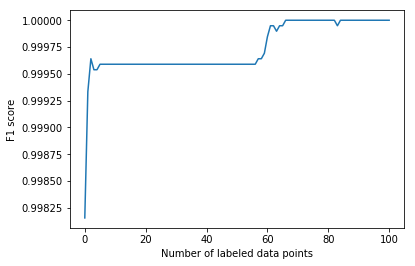

In [494]:
pd.Series(scores).plot()
plt.ylabel('F1 score')
plt.xlabel('Number of labeled data points')

In [498]:
learner = ActiveLearner(
    estimator=RandomForestClassifier(n_estimators=n_estimators),
    query_strategy=uncertainty_sampling,
    X_training=x_train_start.values, y_training=y_train_start.values,
)

scores = [f1_score(y_dev, learner.predict(x_dev))]

indices = np.random.choice(range(len(x_train_pool)), size=100)

for i in range(100):
    # idx, _ = learner.query(x_train_pool.values)
    idx = np.array([indices[i]])
    learner.teach(x_train_pool.iloc[idx, :].values,
                  y_train_pool.iloc[idx].values)
    scores.append(f1_score(y_dev, learner.predict(x_dev)))

Text(0.5,0,'Number of labeled data points')

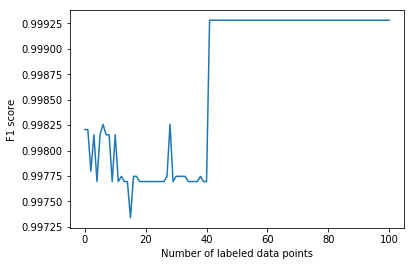

In [499]:
pd.Series(scores).plot()
plt.ylabel('F1 score')
plt.xlabel('Number of labeled data points')

In [504]:
100 * (f1_score(y_dev, learner.predict(x_dev)) / majority_class_f1 - 1)

0.5078485687903811

In [505]:
100 * (1 / majority_class_f1 - 1)

0.5800821355236074

In [501]:
pred_actual_table(learner.predict(x_dev), y_dev)

counts       pct
predicted actual                  
False     False       99  0.010048
True      False       14  0.001421
          True      9740  0.988531

In [515]:
from sklearn.linear_model import LogisticRegression

In [521]:
0.9890313610381586 / majority_class_f1 - 1

-0.005231444721732981

In [519]:
learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=uncertainty_sampling,
    X_training=x_train_start.values, y_training=y_train_start.values,
)

scores = [f1_score(y_dev, learner.predict(x_dev))]

indices = np.random.choice(range(len(x_train_pool)), size=100)

for i in range(100):
    # idx, _ = learner.query(x_train_pool.values)
    idx = np.array([indices[i]])
    learner.teach(x_train_pool.iloc[idx, :].values,
                  y_train_pool.iloc[idx].values)
    scores.append(f1_score(y_dev, learner.predict(x_dev)))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

In [526]:
learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=uncertainty_sampling,
    X_training=x_train_start.values, y_training=y_train_start.values,
)


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [527]:
pred_actual_table(learner.predict(x_dev), y_dev)

counts       pct
predicted actual                  
False     False       47  0.004770
          True       135  0.013701
True      False       66  0.006698
          True      9605  0.974830

In [523]:
scores[-1]

0.9974813672577744

In [525]:
0.9974 / majority_class_f1 - 1

0.0031857392197125467